# AdaBoosting  - Boosting ensemble learning

In [130]:
import pandas as pd 
import numpy as np 

In [131]:
from mlxtend.plotting import plot_decision_regions
df =pd.DataFrame()
df['x1']=[1,2,3,4,5,6,6,7,9,9]
df['x2'] =[5,3,6,8,1,9,5,8,9,2]
df['label'] =[1,1,0,1,0,1,0,1,0,0]

<Axes: xlabel='x1', ylabel='x2'>

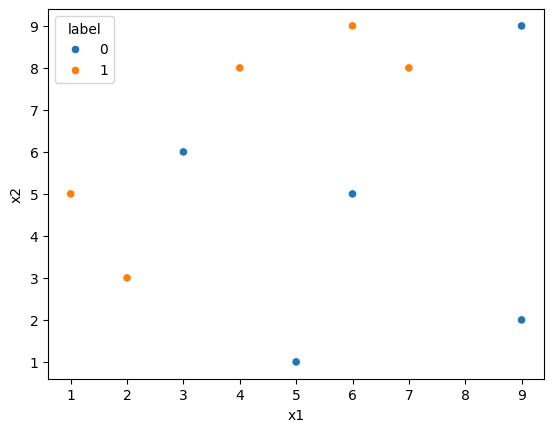

In [132]:
import seaborn as sns
sns.scatterplot(x=df['x1'],y=df['x2'],hue=df['label'])

In [133]:
# step 1 = intialize weights 
df['weights'] = 1/df.shape[0]
df

,x1,x2,label,weights
0,1,5,1,0.1
1,2,3,1,0.1
2,3,6,0,0.1
3,4,8,1,0.1
4,5,1,0,0.1
5,6,9,1,0.1
6,6,5,0,0.1
7,7,8,1,0.1
8,9,9,0,0.1
9,9,2,0,0.1


In [134]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=1)

X =df.iloc[:,0:2].values
y =df.iloc[:,2].values



In [135]:
# step 2  =train the model
dt.fit(X,y)

DecisionTreeClassifier(max_depth=1)

[Text(0.5, 0.75, 'x[1] <= 2.5\ngini = 0.5\nsamples = 10\nvalue = [5, 5]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.469\nsamples = 8\nvalue = [3, 5]'),
 Text(0.625, 0.5, '  False')]

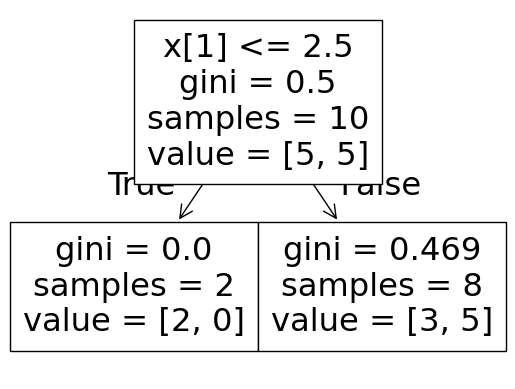

In [136]:
from sklearn.tree import plot_tree
plot_tree(dt)

<Axes: >

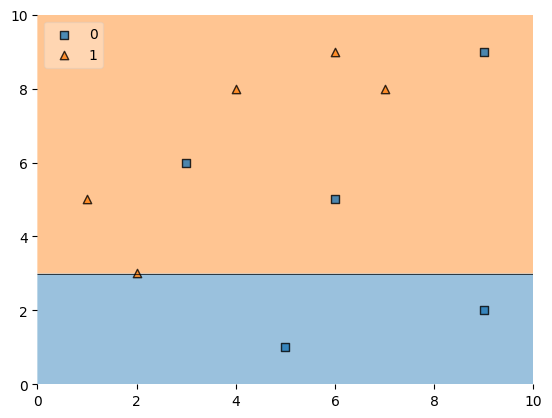

In [137]:
plot_decision_regions(X,y,clf=dt,legend =2)

In [138]:
# calculating y_pred
df['y_pred'] = dt.predict(X)
df

,x1,x2,label,weights,y_pred
0,1,5,1,0.1,1
1,2,3,1,0.1,1
2,3,6,0,0.1,1
3,4,8,1,0.1,1
4,5,1,0,0.1,0
5,6,9,1,0.1,1
6,6,5,0,0.1,1
7,7,8,1,0.1,1
8,9,9,0,0.1,1
9,9,2,0,0.1,0


In [139]:
def calculate_model_weight(error):
    return 0.5*np.log((1-error)/error)



In [140]:
# step 3 = calculate model weight
alpha1 = calculate_model_weight(0.3) # three prediction are wrong so 3*current weight
alpha1

0.42364893019360184

In [141]:
# step 4 = update weights
# for new model
# known as upsampling
def update_weights(row,alpha =0.423):  # alpha = alpha1
    if row['label'] ==row['y_pred']:
        return row ['weights'] * np.exp(-alpha)
    else: 
      return row['weights']*np.exp(alpha)    

In [142]:
df['update_weights'] = df.apply(update_weights,axis=1)
df

,x1,x2,label,weights,y_pred,update_weights
0,1,5,1,0.1,1,0.065508
1,2,3,1,0.1,1,0.065508
2,3,6,0,0.1,1,0.152653
3,4,8,1,0.1,1,0.065508
4,5,1,0,0.1,0,0.065508
5,6,9,1,0.1,1,0.065508
6,6,5,0,0.1,1,0.152653
7,7,8,1,0.1,1,0.065508
8,9,9,0,0.1,1,0.152653
9,9,2,0,0.1,0,0.065508


In [143]:
df['normalized_weights'] = df['update_weights']/df['update_weights'].sum()
df['normalized_weights'].sum()
df

,x1,x2,label,weights,y_pred,update_weights,normalized_weights
0,1,5,1,0.1,1,0.065508,0.071475
1,2,3,1,0.1,1,0.065508,0.071475
2,3,6,0,0.1,1,0.152653,0.166559
3,4,8,1,0.1,1,0.065508,0.071475
4,5,1,0,0.1,0,0.065508,0.071475
5,6,9,1,0.1,1,0.065508,0.071475
6,6,5,0,0.1,1,0.152653,0.166559
7,7,8,1,0.1,1,0.065508,0.071475
8,9,9,0,0.1,1,0.152653,0.166559
9,9,2,0,0.1,0,0.065508,0.071475


In [144]:
df['cumsum_upper'] = np.cumsum(df['normalized_weights'])
df['cumsum_lower'] = df['cumsum_upper'] - df['normalized_weights']

df[['x1','x2','label','y_pred','update_weights','cumsum_lower','cumsum_upper']]


,x1,x2,label,y_pred,update_weights,cumsum_lower,cumsum_upper
0,1,5,1,1,0.065508,0.000000,0.071475
1,2,3,1,1,0.065508,0.071475,0.142950
2,3,6,0,1,0.152653,0.142950,0.309508
3,4,8,1,1,0.065508,0.309508,0.380983
4,5,1,0,0,0.065508,0.380983,0.452458
5,6,9,1,1,0.065508,0.452458,0.523933
6,6,5,0,1,0.152653,0.523933,0.690492
7,7,8,1,1,0.065508,0.690492,0.761967
8,9,9,0,1,0.152653,0.761967,0.928525
9,9,2,0,0,0.065508,0.928525,1.000000


In [145]:
# Upsampling
def create_new_dataset(df):
    indicies =[]
    for i in range(df.shape[0]):
        a =np.random.random()
        for index ,row in df.iterrows():
            if row['cumsum_upper'] > a and a >row['cumsum_lower']:
                indicies.append(index)
    return indicies            

In [146]:
index_values = create_new_dataset(df)
index_values

[5, 7, 0, 2, 7, 8, 5, 6, 1, 4]

In [147]:
second_df =df.iloc[index_values,[0,1,2,3,]]

In [148]:
# repeat from step 2 to create two three model 
# then predict it 

[Text(0.5, 0.75, 'x[1] <= 7.0\ngini = 0.48\nsamples = 10\nvalue = [4, 6]'),
 Text(0.25, 0.25, 'gini = 0.48\nsamples = 5\nvalue = [3, 2]'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.32\nsamples = 5\nvalue = [1, 4]'),
 Text(0.625, 0.5, '  False')]

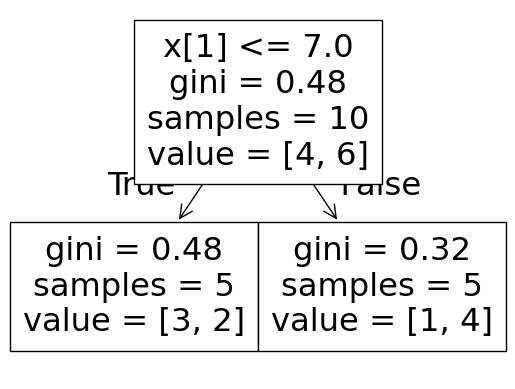

In [149]:

dt2 = DecisionTreeClassifier(max_depth=1)

X = second_df.iloc[:,0:2].values
y = second_df.iloc[:,2].values
dt2.fit(X,y)


plot_tree(dt2)

<Axes: >

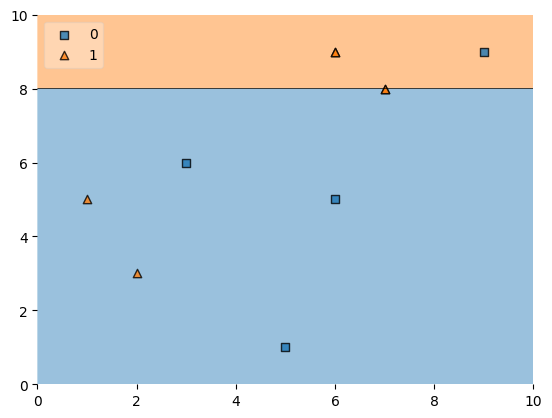

In [150]:
plot_decision_regions(X, y, clf=dt2, legend=2)

In [151]:

second_df['y_pred'] = dt2.predict(X)

alpha2 = calculate_model_weight(0.1)



# Step 4 - Update weights
def update_row_weights(row,alpha=1.09):
  if row['label'] == row['y_pred']:
    return row['weights'] * np.exp(-alpha)
  else:
    return row['weights'] * np.exp(alpha)


second_df['updated_weights'] = second_df.apply(update_row_weights,axis=1)

second_df['nomalized_weights'] = second_df['updated_weights']/second_df['updated_weights'].sum()

second_df['cumsum_upper'] = np.cumsum(second_df['nomalized_weights'])
second_df['cumsum_lower'] = second_df['cumsum_upper'] - second_df['nomalized_weights']

second_df[['x1','x2','label','weights','y_pred','nomalized_weights','cumsum_lower','cumsum_upper']]
 
index_values = create_new_dataset(second_df)   



third_df = second_df.iloc[index_values,[0,1,2,3]] 
     
     

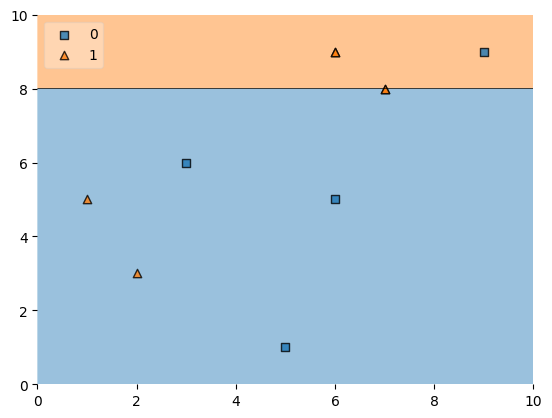

In [152]:

dt3 = DecisionTreeClassifier(max_depth=1)

X = second_df.iloc[:,0:2].values
y = second_df.iloc[:,2].values

dt3.fit(X,y)

plot_decision_regions(X, y, clf=dt3, legend=2)

third_df['y_pred'] = dt3.predict(X)
alpha3 = calculate_model_weight(0.7)

     

In [153]:


print(alpha1,alpha2,alpha3)

0.42364893019360184 1.0986122886681098 -0.4236489301936017



# Prediction


In [154]:


query = np.array([1,5]).reshape(1,2)
dt.predict(query)




array([1], dtype=int64)

In [155]:
dt2.predict(query)

array([0], dtype=int64)

In [156]:
dt3.predict(query)

array([0], dtype=int64)

In [157]:

alpha1*1 + alpha2*(1) + alpha3*(-1)


1.9459101490553135

In [158]:
np.sign(1.94)

1.0

# Ada Boost Hypermeter

<Axes: >

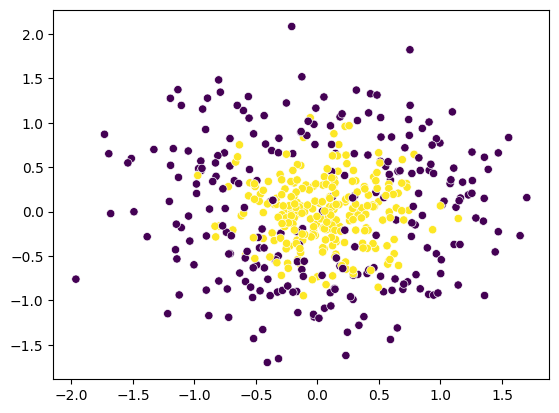

In [159]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
np.random.seed(42)
X,y  = make_circles(n_samples=500,factor =0.1,noise=0.35,random_state=42)
X_train ,X_test ,Y_train,Y_test = train_test_split(X,y ,test_size=0.2)

sns.scatterplot(x =X[:,0],y=X[:,1],c=y)


In [160]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

abc =AdaBoostClassifier()
np.mean(cross_val_score(abc,X,y,scoring='accuracy',cv=10))

C:\Users\dell\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dell\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dell\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dell\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the S

0.786

In [161]:
abc.fit(X,y)



C:\Users\dell\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier()

In [162]:
import matplotlib.pyplot as plt

In [163]:
def plot_decision_boundary(clf):
    plt.figure(figsize=(12,8))
    plt.figure(facecolor='lightgray')
    #plt.gca().set_facecolor('lightblue')
    
    X_range = np.linspace(X.min(),X.max(),100)
    
    xx1,xx2 = np.meshgrid(X_range,X_range)
    
    y_hat = clf.predict(np.c_[xx1.ravel(),xx2.ravel()])
    
    y_hat = y_hat.reshape(xx1.shape)
    plt.contour(xx1,xx2,y_hat,alpha=0.2)
    plt.scatter(X[:,0],X[:,1],c=y ,cmap='viridis',alpha =.7)
    plt.title('AdaBoostClassifier')
    plt.show()

<Figure size 1200x800 with 0 Axes>

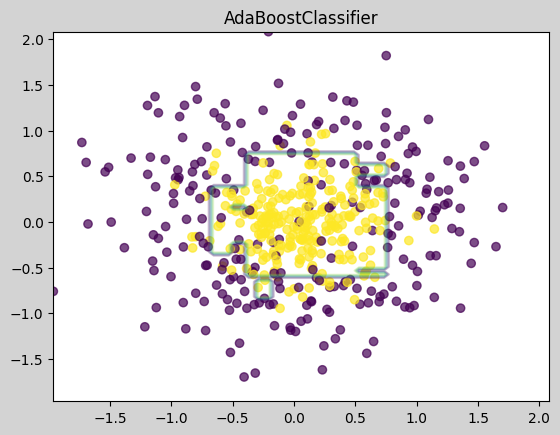

In [164]:
plot_decision_boundary(clf=abc)

C:\Users\dell\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


<Figure size 1200x800 with 0 Axes>

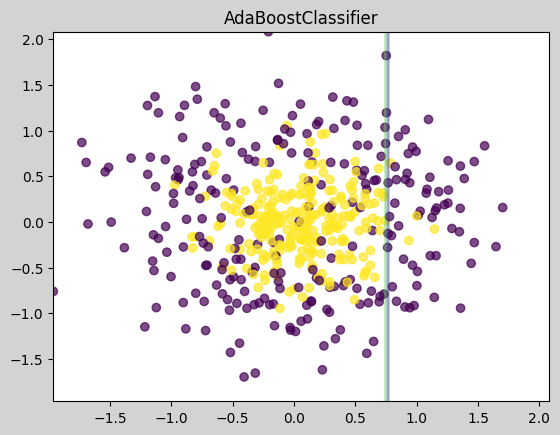

In [165]:
abc =AdaBoostClassifier(n_estimators=1)
abc.fit(X,y)
plot_decision_boundary(abc)

In [166]:
from sklearn.model_selection import GridSearchCV

grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
grid['algorithm'] = ['SAMME', 'SAMME.R']


grid_search = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=grid, n_jobs=-1, cv=10, scoring='accuracy')
# execute the grid search
grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.832000 using {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 500}
